In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from os.path import isfile
import pandas as pd
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools, geo_tools
import glob
import gsw
import pytz
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates

mpl.rc('xtick', labelsize=16)
mpl.rc('ytick', labelsize=16)
mpl.rc('legend', fontsize=12)
mpl.rc('axes', titlesize=16)
mpl.rc('axes', labelsize=16)
mpl.rc('figure', titlesize=16)
mpl.rc('font', size=16)

%matplotlib inline

In [2]:
f0 = pd.read_excel('/ocean/eolson/MEOPAR/obs/Hakai/Dosser20180911/2018-09-11_144804_HakaiData_nutrients.xlsx',
                 sheetname = 'Hakai Data')
f0.drop(['ACTION','Lat', 'Long', 'Collection Method', 'Installed', 'Lab Technician', 'NH4+', 'NO2+NO3 (ug/L)',
       'no2_no3_units', 'TP', 'TDP', 'TN', 'TDN', 'SRP', 'Project Specific ID', 'Hakai ID', 'Source',
       'po4pfilt', 'no3nfilt', 'po4punfl', 'no3nunfl', 'nh4nunfl', 'NH4+ Flag',
       'TP FLag', 'TDP FLag', 'TN Flag', 'TDN FLag','Volume (ml)',
       'SRP Flag', 'PO4 Flag', 'po4pfilt_flag', 'no3nfilt_flag','Preserved', 'Analyzed',
       'po4punfl_flag', 'no3nunfl_flag', 'nh4nunfl_flag', 'Analyzing Lab', 'Sample Status',
       'Quality Level', 'Comments', 'Quality Log'], axis = 1, inplace = True)
dts0=[pytz.timezone('Canada/Pacific').localize(i).astimezone(pytz.utc).replace(tzinfo=None)
        for i in f0['Collected']]
f0['dtUTC']=dts0
f0.keys()

Index(['no', 'event_pk', 'Replicate Number', 'Date', 'Work Area', 'Survey',
       'Sampling Bout', 'Site ID', 'Gather Lat', 'Gather Long',
       'Line Out Depth', 'Pressure Transducer Depth (m)', 'Filter Type',
       'Collected', 'NO2+NO3 (uM)', 'PO4', 'SiO2', 'NO2+NO3 Flag', 'SiO2 Flag',
       'dtUTC'],
      dtype='object')

In [3]:
f0.head()

,no,event_pk,Replicate Number,Date,Work Area,Survey,Sampling Bout,Site ID,Gather Lat,Gather Long,Line Out Depth,Pressure Transducer Depth (m),Filter Type,Collected,NO2+NO3 (uM),PO4,SiO2,NO2+NO3 Flag,SiO2 Flag,dtUTC
0,3483,4455,1,2014-11-07,QUADRA,QOMA,1,QU5,NaN,NaN,0.0,NaN,0.45nm,2014-11-07 11:30:39,17.528459,1.480,37.597988,NaN,NaN,2014-11-07 19:30:39
1,3484,4467,1,2014-11-07,QUADRA,QOMA,1,QU17,NaN,NaN,0.0,NaN,0.45nm,2014-11-07 10:30:30,19.534208,1.637,39.536296,NaN,NaN,2014-11-07 18:30:30
2,3485,4460,1,2014-11-07,QUADRA,QOMA,1,QU24,NaN,NaN,0.0,NaN,0.45nm,2014-11-07 09:30:32,20.243301,1.671,38.212329,NaN,NaN,2014-11-07 17:30:32
3,3486,4455,1,2014-11-07,QUADRA,QOMA,1,QU5,NaN,NaN,5.0,NaN,0.45nm,2014-11-07 11:30:39,19.414687,1.621,38.879558,NaN,NaN,2014-11-07 19:30:39
4,3487,4467,1,2014-11-07,QUADRA,QOMA,1,QU17,NaN,NaN,5.0,NaN,0.45nm,2014-11-07 10:30:30,19.728054,1.646,39.173135,NaN,NaN,2014-11-07 18:30:30


In [4]:
fc = pd.read_csv('/ocean/eolson/MEOPAR/obs/Hakai/Dosser20180911/ctd-bulk-1536702711696.csv',
                usecols=['Cast PK','Cruise','Station', 'Drop number','Start time', 'Bottom time',
                         'Latitude', 'Longitude', 'Depth (m)', 'Temperature (deg C)', 'Temperature flag', 'Pressure (dbar)',
                         'Pressure flag', 'PAR', 'PAR flag', 'Fluorometry Chlorophyll (ug/L)', 'Fluorometry Chlorophyll flag',
                         'Turbidity (FTU)', 'Turbidity flag',
                         'Salinity (PSU)', 'Salinity flag'],
                dtype={'Drop number':np.float64,'PAR flag':str,'Fluorometry Chlorophyll flag':str},na_values='null')

In [5]:
## fix apparent typos:
# reversed lats and lons
iii=fc['Latitude']>90
lons=-1*fc.loc[iii,'Latitude'].values
lats=-1*fc.loc[iii,'Longitude'].values
fc.loc[iii,'Longitude']=lons
fc.loc[iii,'Latitude']=lats

# remove data with missing lats and lons
nans=fc.loc[(fc['Latitude'].isnull())|(fc['Longitude'].isnull())]
fc=fc.drop(nans.index)

# apparently bad lats/lons
QU16bad=fc.loc[(fc['Station']=='QU16')&(fc['Latitude']>50.3)]
fc=fc.drop(QU16bad.index)
QU36bad=fc.loc[(fc['Station']=='QU36')&(fc['Latitude']>50.2)]
fc=fc.drop(QU36bad.index)
QU37bad=fc.loc[(fc['Station']=='QU37')&(fc['Longitude']<-125.1)]
fc=fc.drop(QU37bad.index)
QU38bad=fc.loc[(fc['Station']=='QU38')&(fc['Longitude']>-125.2)]
fc=fc.drop(QU38bad.index)
QU5bad=fc.loc[(fc['Station']=='QU5')&(fc['Longitude']>-125.18)]
fc=fc.drop(QU5bad.index)
#np.unique(fc.loc[(fc['Station']==sta)&(fc['Longitude']>-125.18)]['Cruise'].values)

In [6]:
fc.head()

,Cast PK,Cruise,Station,Drop number,Start time,Bottom time,Latitude,Longitude,Depth (m),Temperature (deg C),...,Pressure (dbar),Pressure flag,PAR,PAR flag,Fluorometry Chlorophyll (ug/L),Fluorometry Chlorophyll flag,Turbidity (FTU),Turbidity flag,Salinity (PSU),Salinity flag
0,1,QOM A,QU40,1.0,2015-11-03 12:37:20.000,2015-11-03 12:41:03.000,50.092435,-125.164387,0.991,10.6879,...,1,NaN,232.550,NaN,0.28830,NaN,0.742,NaN,28.1286,NaN
1,1,QOM A,QU40,1.0,2015-11-03 12:37:20.000,2015-11-03 12:41:03.000,50.092435,-125.164387,1.983,10.8076,...,2,NaN,146.550,NaN,0.36906,NaN,0.827,NaN,28.2369,NaN
2,1,QOM A,QU40,1.0,2015-11-03 12:37:20.000,2015-11-03 12:41:03.000,50.092435,-125.164387,2.974,10.8952,...,3,NaN,108.020,NaN,0.45831,NaN,0.742,NaN,28.3184,NaN
3,1,QOM A,QU40,1.0,2015-11-03 12:37:20.000,2015-11-03 12:41:03.000,50.092435,-125.164387,3.966,10.9617,...,4,NaN,92.601,NaN,0.49377,NaN,0.776,NaN,28.3926,NaN
4,1,QOM A,QU40,1.0,2015-11-03 12:37:20.000,2015-11-03 12:41:03.000,50.092435,-125.164387,4.957,11.0704,...,5,NaN,81.387,NaN,0.57567,NaN,0.718,NaN,28.5540,NaN


In [7]:
fc.keys()

Index(['Cast PK', 'Cruise', 'Station', 'Drop number', 'Start time',
       'Bottom time', 'Latitude', 'Longitude', 'Depth (m)',
       'Temperature (deg C)', 'Temperature flag', 'Pressure (dbar)',
       'Pressure flag', 'PAR', 'PAR flag', 'Fluorometry Chlorophyll (ug/L)',
       'Fluorometry Chlorophyll flag', 'Turbidity (FTU)', 'Turbidity flag',
       'Salinity (PSU)', 'Salinity flag'],
      dtype='object')

In [8]:
fc['dt']=[dt.datetime.strptime(i.split('.')[0],'%Y-%m-%d %H:%M:%S') for i in fc['Start time']]

In [9]:
fc['dt'][0].hour

12

In [10]:
hh=[ii.hour for ii in fc['dt']]

(array([  2769.,  11727.,  26700.,  68449.,  86168.,  83460.,  67215.,
         37648.,  11945.,   3597.]),
 array([  6.,   7.,   8.,   9.,  10.,  11.,  12.,  13.,  14.,  15.,  16.]),
 <a list of 10 Patch objects>)

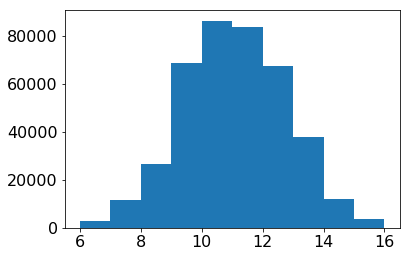

In [11]:
plt.hist(hh)
# looks like times are local vancouver time since people usually sample during daylight....

In [12]:
fc['dt']=[dt.datetime.strptime(i.split('.')[0],'%Y-%m-%d %H:%M:%S') for i in fc['Start time']]
dts=[pytz.timezone('Canada/Pacific').localize(dt.datetime.strptime(i.split('.')[0],'%Y-%m-%d %H:%M:%S')).astimezone(pytz.utc).replace(tzinfo=None)
        for i in fc['Start time']]
fc['dtUTC']=dts

In [13]:
dloc=[dt.datetime(i.year,i.month,i.day) for i in fc['dt']]
fc['dloc']=dloc

In [14]:
48/8

6.0

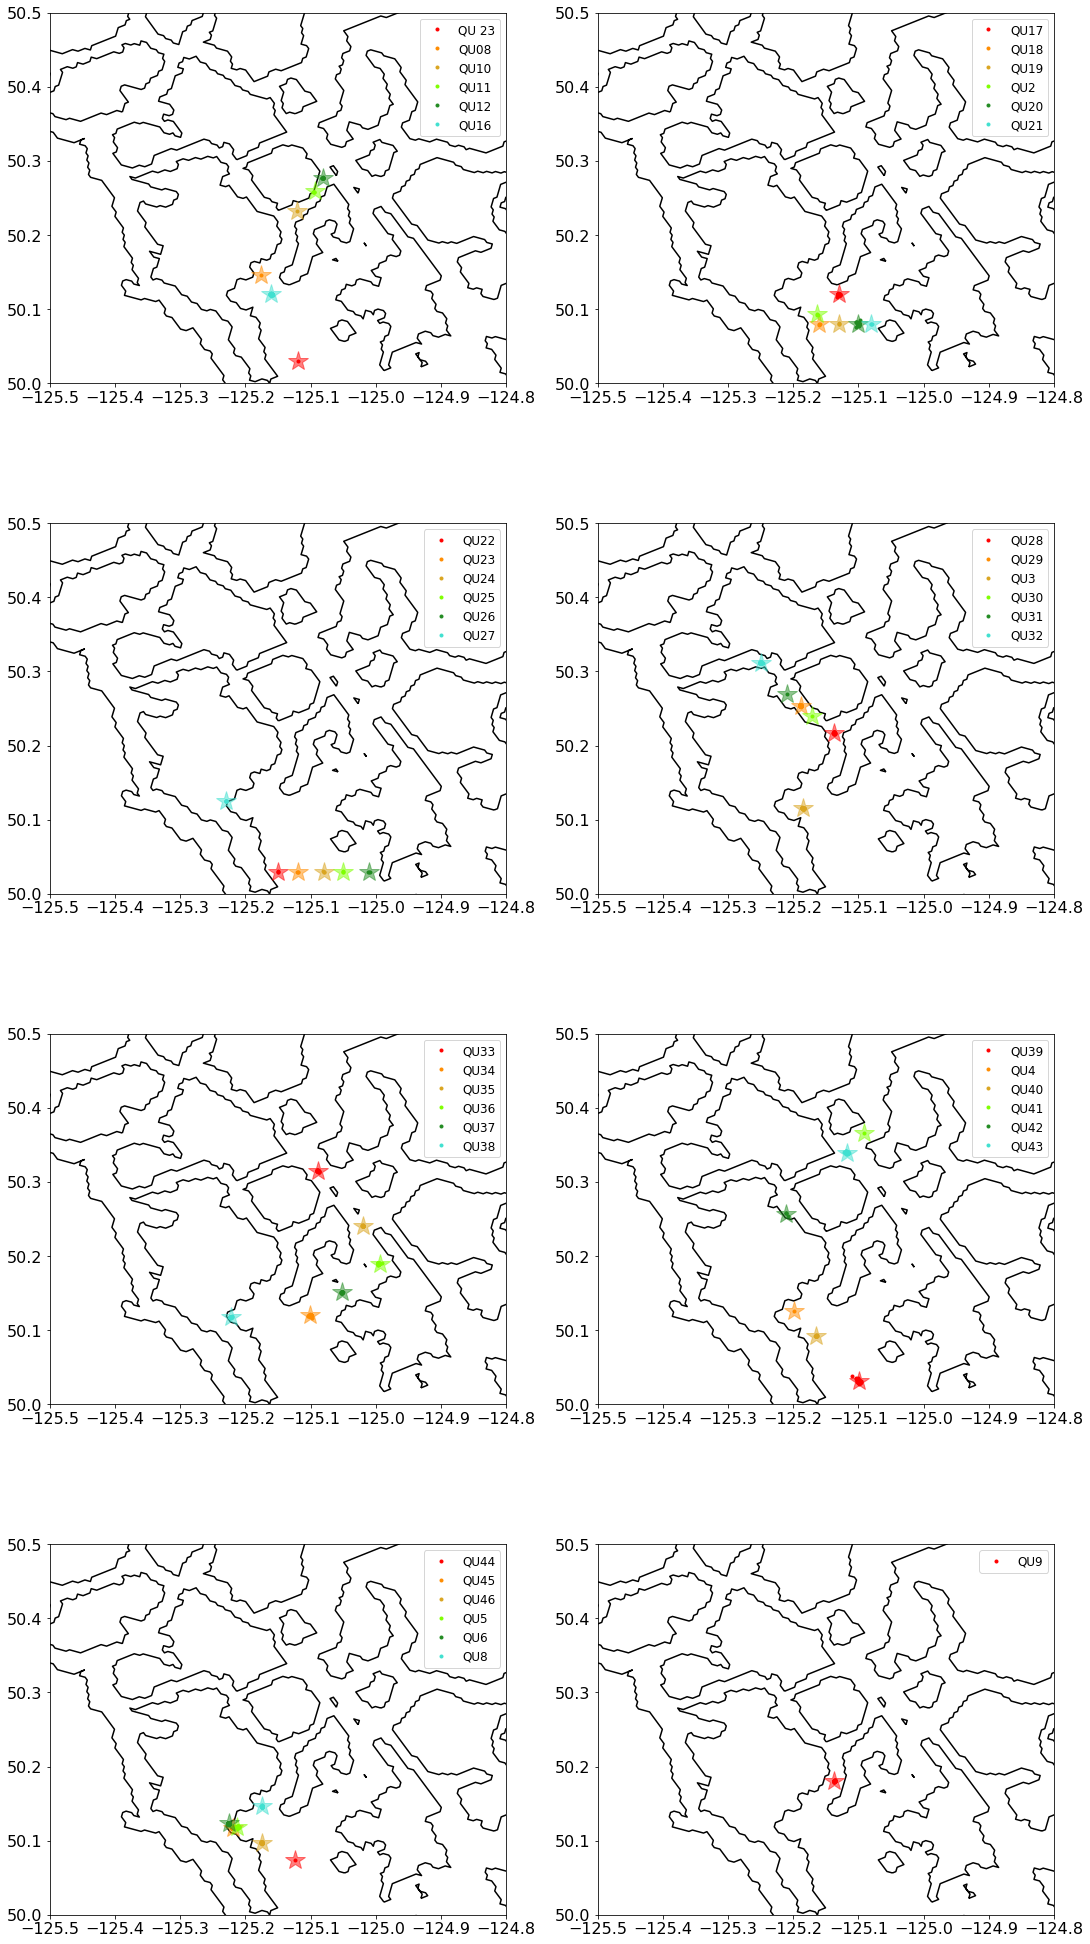

In [15]:
fig,ax=plt.subplots(4,2,figsize=(18,36))
axf=ax.flatten()
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
for axi in axf:
    viz_tools.set_aspect(axi, coords = 'map')
    viz_tools.plot_coastline(axi, grid, coords = 'map')
    axi.set_xlim(-125.5,-124.8)
    axi.set_ylim(50,50.5)

cols=['red','darkorange','goldenrod','chartreuse','forestgreen','turquoise','darkviolet']
count=0
axi=0
namelist=list()
ps=list()
for name, group in fc.groupby('Station'): 
    meanlon=np.nanmean(group['Longitude'].values)
    meanlat=np.nanmean(group['Latitude'].values)
    if count==6:
        axf[axi].legend(handles=ps)
        axi=axi+1
        count=0
        namelist=list()
        ps=list()
    # print the name of the regiment
    ll=np.unique([(i,j) for i,j in zip(group['Latitude'].values,group['Longitude'].values)],axis=0)
    for el in ll:
        p,=axf[axi].plot(el[1],el[0],'.',color=cols[count%6],label=name)
        if not name in namelist:
            namelist.append(name)
            ps.append(p)
    axf[axi].plot(meanlon,meanlat,'*',color=cols[count%6],alpha=.5,markersize=20)
    count=count+1
axf[axi].legend(handles=ps)

In [16]:
fcS=fc.loc[:,['Latitude','Longitude']].groupby([fc['Station'],fc['dloc']]).mean().reset_index()

In [17]:
fcS.head()

,Station,dloc,Latitude,Longitude
0,QU 23,2014-08-28,50.030000,-125.120000
1,QU 23,2014-10-09,50.030000,-125.120000
2,QU 23,2014-10-29,50.030000,-125.120000
3,QU08,2016-12-01,50.146282,-125.175323
4,QU10,2014-08-15,50.232300,-125.120700


In [18]:
f0['Station']=f0['Site ID']
#f0['dt']=[dt.datetime.strptime(i,'%Y-%m-%d %H:%M:%S') for i in f0['Collected']]
dloc0=[dt.datetime(i.year,i.month,i.day) for i in f0['Collected']]
f0['dloc']=dloc0

In [19]:
fdata=f0.merge(fcS,how='left')

In [20]:
len(fdata.loc[fdata['Latitude'].isnull()]),len(fdata.loc[fdata['Latitude']>=0])

(247, 3997)

In [21]:
fdata['Lat']=fdata['Latitude']
fdata['Lon']=fdata['Longitude']
fdata['Z']=fdata['Line Out Depth']

In [22]:
PATH= '/results/SalishSea/hindcast/'
start_date = dt.datetime(2015,1,1)
end_date = dt.datetime(2017,1,1)
flen=1
namfmt='nowcast'
filemap={'nitrate':'ptrc_T','silicon':'ptrc_T','ammonium':'ptrc_T','diatoms':'ptrc_T','ciliates':'ptrc_T','flagellates':'ptrc_T'}
fdict={'ptrc_T':1,'grid_T':1}

In [23]:
fdata2=fdata.loc[(fdata['dtUTC']>start_date)&(fdata['dtUTC']<end_date)&(fdata['Z']>=0)&(fdata['Z']<440)&(fdata['Lon']<360)&(fdata['Lat']<=90)].copy(deep=True).reset_index()

In [24]:
data=et.matchData(fdata2,filemap, fdict, start_date, end_date, namfmt, PATH, flen)

In [25]:
data.keys()

Index(['index', 'no', 'event_pk', 'Replicate Number', 'Date', 'Work Area',
       'Survey', 'Sampling Bout', 'Site ID', 'Gather Lat', 'Gather Long',
       'Line Out Depth', 'Pressure Transducer Depth (m)', 'Filter Type',
       'Collected', 'NO2+NO3 (uM)', 'PO4', 'SiO2', 'NO2+NO3 Flag', 'SiO2 Flag',
       'dtUTC', 'Station', 'dloc', 'Latitude', 'Longitude', 'Lat', 'Lon', 'Z',
       'j', 'i', 'mod_nitrate', 'mod_silicon', 'mod_ammonium', 'mod_diatoms',
       'mod_ciliates', 'mod_flagellates'],
      dtype='object')

In [26]:
data['N']=data['NO2+NO3 (uM)']
data['Si']=data['SiO2']

## Figures

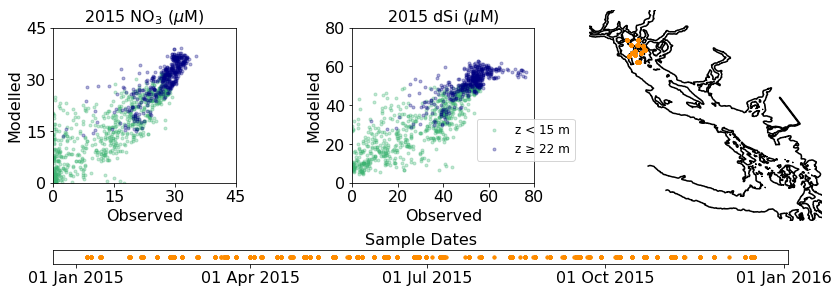

In [27]:
# 2015
data2015=data.loc[(data.dtUTC>=dt.datetime(2015,1,1))&(data.dtUTC<dt.datetime(2016,1,1))]
idata=data2015
yy='2015'
fig = plt.figure(figsize = (12,4))
gs1 = gridspec.GridSpec(2,3,left=.08,right=.93,hspace=.8,wspace=.7,bottom=.08,top=.9,height_ratios=[5.8,.5],width_ratios=[4,4,3])
ax1 = fig.add_subplot(gs1[0,0])
ax2 = fig.add_subplot(gs1[0,1])
ax3 = fig.add_subplot(gs1[0,2])
axb = fig.add_subplot(gs1[1, :])

ps=et.varvarPlot(ax1,idata,'N','mod_nitrate','Z',(15,22),'z','m',('mediumseagreen','darkturquoise','navy'))
for el in ps:
    el.set_alpha(.3)
#ax1.legend(handles=ps)
ax1.set_xlabel('Observed')
ax1.set_ylabel('Modelled')
ax1.set_title(yy+' NO$_3$ ($\mu$M)')
ax1.set_xlim((0,45))
ax1.set_ylim((0,45))
ntick=np.arange(0,56,15)
ntickl=[str(i) for i in ntick]
ax1.set_xticks(ntick)
ax1.set_xticklabels(ntickl)
ax1.set_yticks(ntick)
ax1.set_yticklabels(ntickl)

ps=et.varvarPlot(ax2,idata,'Si','mod_silicon','Z',(15,22),'z','m',('mediumseagreen','darkturquoise','navy'))
for el in ps:
    el.set_alpha(.3)
ax2.legend(handles=ps,bbox_to_anchor=[.65,.45])
ax2.set_xlabel('Observed')
ax2.set_ylabel('Modelled')
ax2.set_title(yy+' dSi ($\mu$M)')
ax2.set_xlim((0,80))
ax2.set_ylim((0,80))
ntick=np.arange(0,81,20)
ntickl=[str(i) for i in ntick]
ax2.set_xticks(ntick)
ax2.set_xticklabels(ntickl)
ax2.set_yticks(ntick)
ax2.set_yticklabels(ntickl)

viz_tools.set_aspect(ax3, coords = 'map')
datanut=idata.loc[(idata.N>=0)|(idata.Si>=0)]
ax3.plot(datanut['Lon'], datanut['Lat'], '.',color='darkorange',label='data',markersize=6)
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
viz_tools.plot_coastline(ax3, grid, coords = 'map')
ax3.set_ylim(48, 50.7)
#ax3.legend()
ax3.set_xlim(-125.8, -122.4);
ax3.axis('off')
test=ax3.get_position()
ax3.set_position(mpl.transforms.Bbox(points=[[.7,.2],[.97,.99]]))

axb.plot(datanut.dtUTC,np.ones(np.shape(datanut.dtUTC)),'.',color='darkorange',markersize=6)
axb.set_yticks(());
yearsFmt = mdates.DateFormatter('%d %b %Y')
axb.xaxis.set_major_formatter(yearsFmt)
axb.xaxis.set_ticks([dt.datetime(int(yy),1,1), dt.datetime(int(yy),4,1),dt.datetime(int(yy),7,1),dt.datetime(int(yy),10,1),dt.datetime(int(yy)+1,1,1)])
#axb.autofmt_xdate(bottom=0.2, rotation=15, ha='right')
#axb.set_title('Sampling Dates')
#plt.setp(plt.xticks()[1], rotation=10, ha='right')
axb.set_title('Sample Dates')
fig.savefig('/home/eolson/pyCode/notebooks/figs/EvalHakai2015.png',dpi=200,transparent=True)

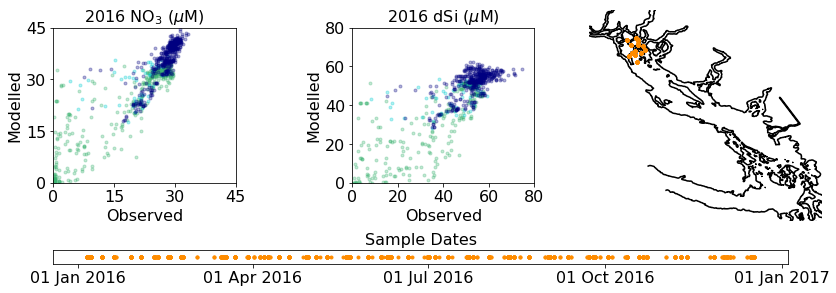

In [28]:
# 2016
data2016=data.loc[(data.dtUTC>=dt.datetime(2016,1,1))&(data.dtUTC<dt.datetime(2017,1,1))]
idata=data2016
yy='2016'
fig = plt.figure(figsize = (12,4))
gs1 = gridspec.GridSpec(2,3,left=.08,right=.93,hspace=.8,wspace=.7,bottom=.08,top=.9,height_ratios=[5.8,.5],width_ratios=[4,4,3])
ax1 = fig.add_subplot(gs1[0,0])
ax2 = fig.add_subplot(gs1[0,1])
ax3 = fig.add_subplot(gs1[0,2])
axb = fig.add_subplot(gs1[1, :])

ps=et.varvarPlot(ax1,idata,'N','mod_nitrate','Z',(15,22),'z','m',('mediumseagreen','darkturquoise','navy'))
for el in ps:
    el.set_alpha(.3)
#ax1.legend(handles=ps)
ax1.set_xlabel('Observed')
ax1.set_ylabel('Modelled')
ax1.set_title(yy+' NO$_3$ ($\mu$M)')
ax1.set_xlim((0,45))
ax1.set_ylim((0,45))
ntick=np.arange(0,56,15)
ntickl=[str(i) for i in ntick]
ax1.set_xticks(ntick)
ax1.set_xticklabels(ntickl)
ax1.set_yticks(ntick)
ax1.set_yticklabels(ntickl)

ps=et.varvarPlot(ax2,idata,'Si','mod_silicon','Z',(15,22),'z','m',('mediumseagreen','darkturquoise','navy'))
for el in ps:
    el.set_alpha(.3)
#ax2.legend(handles=ps,bbox_to_anchor=[.65,.4])
ax2.set_xlabel('Observed')
ax2.set_ylabel('Modelled')
ax2.set_title(yy+' dSi ($\mu$M)')
ax2.set_xlim((0,80))
ax2.set_ylim((0,80))
ntick=np.arange(0,81,20)
ntickl=[str(i) for i in ntick]
ax2.set_xticks(ntick)
ax2.set_xticklabels(ntickl)
ax2.set_yticks(ntick)
ax2.set_yticklabels(ntickl)

viz_tools.set_aspect(ax3, coords = 'map')
datanut=idata.loc[(idata.N>=0)|(idata.Si>=0)]
ax3.plot(datanut['Lon'], datanut['Lat'], '.',color='darkorange',label='data',markersize=6)
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
viz_tools.plot_coastline(ax3, grid, coords = 'map')
ax3.set_ylim(48, 50.7)
#ax3.legend()
ax3.set_xlim(-125.8, -122.4);
ax3.axis('off')
test=ax3.get_position()
ax3.set_position(mpl.transforms.Bbox(points=[[.7,.2],[.97,.99]]))

axb.plot(datanut.dtUTC,np.ones(np.shape(datanut.dtUTC)),'.',color='darkorange',markersize=6)
axb.set_yticks(());
yearsFmt = mdates.DateFormatter('%d %b %Y')
axb.xaxis.set_major_formatter(yearsFmt)
axb.xaxis.set_ticks([dt.datetime(int(yy),1,1), dt.datetime(int(yy),4,1),dt.datetime(int(yy),7,1),dt.datetime(int(yy),10,1),dt.datetime(int(yy)+1,1,1)])
#axb.autofmt_xdate(bottom=0.2, rotation=15, ha='right')
#axb.set_title('Sampling Dates')
#plt.setp(plt.xticks()[1], rotation=10, ha='right')
axb.set_title('Sample Dates')
fig.savefig('/home/eolson/pyCode/notebooks/figs/EvalHakai2016.png',dpi=200,transparent=True)